# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(284216 + 285155)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

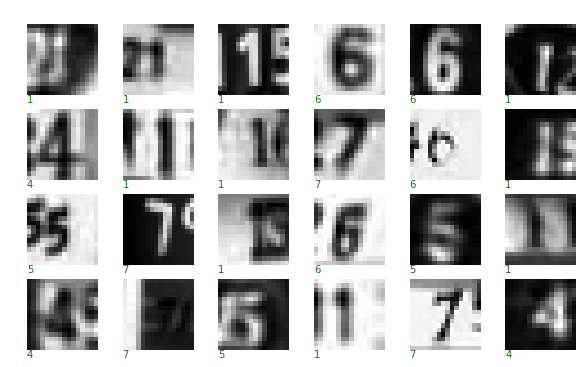

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [8]:
ex1_model = Sequential([
    Dense(5, input_shape=(256,), activation='softmax'),
])

ex1_model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ex1_history = ex1_model.fit(x_train, y_train, epochs=500, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 45060 samples, validate on 16248 samples
Epoch 1/500
45060/45060 [==============================] - 4s 83us/step - loss: 1.5816 - acc: 0.2995 - val_loss: 1.5691 - val_acc: 0.3120
Epoch 2/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.5651 - acc: 0.3110 - val_loss: 1.5595 - val_acc: 0.3151
Epoch 3/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.5580 - acc: 0.3137 - val_loss: 1.5517 - val_acc: 0.3184
Epoch 4/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.5526 - acc: 0.3169 - val_loss: 1.5501 - val_acc: 0.3178
Epoch 5/500
45060/45060 [==============================] - 1s 16us/step - loss: 1.5485 - acc: 0.3183 - val_loss: 1.5468 - val_acc: 0.3175
Epoch 6/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.5451 - acc: 0.3213 - val_loss: 1.5412 - val_acc: 0.3263
Epoch 7/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.5421 - acc: 0.3248 - val_loss: 1.5401 - 

Epoch 118/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.4938 - acc: 0.3925 - val_loss: 1.5341 - val_acc: 0.3743
Epoch 119/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4936 - acc: 0.3930 - val_loss: 1.5334 - val_acc: 0.3790
Epoch 120/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4936 - acc: 0.3935 - val_loss: 1.5349 - val_acc: 0.3855
Epoch 121/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4936 - acc: 0.3944 - val_loss: 1.5334 - val_acc: 0.3808
Epoch 122/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.4934 - acc: 0.3941 - val_loss: 1.5331 - val_acc: 0.3794
Epoch 123/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4932 - acc: 0.3932 - val_loss: 1.5349 - val_acc: 0.3772
Epoch 124/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4932 - acc: 0.3938 - val_loss: 1.5341 - val_acc: 0.3704
Epoch 125/500
45060/

45060/45060 [==============================] - 1s 16us/step - loss: 1.4876 - acc: 0.4014 - val_loss: 1.5399 - val_acc: 0.3908
Epoch 235/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4876 - acc: 0.4010 - val_loss: 1.5372 - val_acc: 0.3841
Epoch 236/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4874 - acc: 0.4009 - val_loss: 1.5383 - val_acc: 0.3818
Epoch 237/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4875 - acc: 0.4017 - val_loss: 1.5381 - val_acc: 0.3887
Epoch 238/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4875 - acc: 0.4022 - val_loss: 1.5372 - val_acc: 0.3823
Epoch 239/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4874 - acc: 0.4016 - val_loss: 1.5371 - val_acc: 0.3815
Epoch 240/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.4874 - acc: 0.4010 - val_loss: 1.5395 - val_acc: 0.3877
Epoch 241/500
45060/45060 [=======

45060/45060 [==============================] - 1s 14us/step - loss: 1.4848 - acc: 0.4040 - val_loss: 1.5449 - val_acc: 0.3872
Epoch 351/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4849 - acc: 0.4055 - val_loss: 1.5395 - val_acc: 0.3879
Epoch 352/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4848 - acc: 0.4045 - val_loss: 1.5393 - val_acc: 0.3813
Epoch 353/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4847 - acc: 0.4039 - val_loss: 1.5388 - val_acc: 0.3810
Epoch 354/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4847 - acc: 0.4040 - val_loss: 1.5395 - val_acc: 0.3872
Epoch 355/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4847 - acc: 0.4051 - val_loss: 1.5408 - val_acc: 0.3878
Epoch 356/500
45060/45060 [==============================] - 1s 14us/step - loss: 1.4847 - acc: 0.4040 - val_loss: 1.5431 - val_acc: 0.3917
Epoch 357/500
45060/45060 [=======

45060/45060 [==============================] - 1s 13us/step - loss: 1.4830 - acc: 0.4069 - val_loss: 1.5415 - val_acc: 0.3858
Epoch 467/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.4830 - acc: 0.4063 - val_loss: 1.5405 - val_acc: 0.3861
Epoch 468/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.4830 - acc: 0.4067 - val_loss: 1.5409 - val_acc: 0.3842
Epoch 469/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.4831 - acc: 0.4064 - val_loss: 1.5407 - val_acc: 0.3856
Epoch 470/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.4831 - acc: 0.4071 - val_loss: 1.5402 - val_acc: 0.3828
Epoch 471/500
45060/45060 [==============================] - 1s 13us/step - loss: 1.4829 - acc: 0.4059 - val_loss: 1.5412 - val_acc: 0.3874
Epoch 472/500
45060/45060 [==============================] - 1s 15us/step - loss: 1.4831 - acc: 0.4069 - val_loss: 1.5411 - val_acc: 0.3880
Epoch 473/500
45060/45060 [=======

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


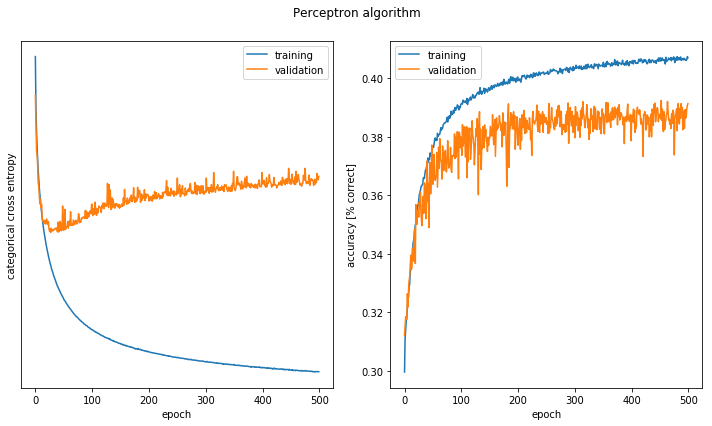

Test loss: 1.54326961881
Test accuracy: 0.391309699663


In [9]:
ex1_model.summary()
plot_history(ex1_history, "Perceptron algorithm")
plt.show()

score = ex1_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

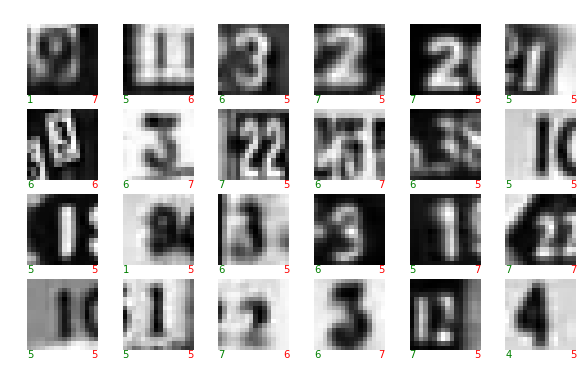

In [72]:
yhat_test = ex1_model.predict_on_batch(x_test)
error = np.linalg.norm(((yhat_test.round()) - y_test),axis=1)
error_indices = np.nonzero(error)[0]

plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)
plt.show()

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [12]:
ex2_model_sgd = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [13]:
lrates = [0.01, 0.05, 0.1, 0.3, 0.5, 0.9, 1, 2]
histories = []
for lrate in lrates:
    ex2_model_sgd.compile(optimizer=SGD(lr=lrate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    histories.append(ex2_model_sgd.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1))

Train on 45060 samples, validate on 16248 samples
Epoch 1/50
45060/45060 [==============================] - 1s 32us/step - loss: 1.5567 - acc: 0.3067 - val_loss: 1.5355 - val_acc: 0.3157
Epoch 2/50
45060/45060 [==============================] - 1s 32us/step - loss: 1.5370 - acc: 0.3179 - val_loss: 1.5212 - val_acc: 0.3487
Epoch 3/50
45060/45060 [==============================] - 1s 31us/step - loss: 1.5246 - acc: 0.3319 - val_loss: 1.5090 - val_acc: 0.3603
Epoch 4/50
45060/45060 [==============================] - 1s 27us/step - loss: 1.5128 - acc: 0.3426 - val_loss: 1.4973 - val_acc: 0.3782
Epoch 5/50
45060/45060 [==============================] - 1s 23us/step - loss: 1.5006 - acc: 0.3543 - val_loss: 1.4862 - val_acc: 0.3994
Epoch 6/50
45060/45060 [==============================] - 1s 23us/step - loss: 1.4872 - acc: 0.3669 - val_loss: 1.4694 - val_acc: 0.3973
Epoch 7/50
45060/45060 [==============================] - 1s 22us/step - loss: 1.4722 - acc: 0.3793 - val_loss: 1.4563 - val_acc

Epoch 10/50
45060/45060 [==============================] - 1s 24us/step - loss: 0.6537 - acc: 0.8024 - val_loss: 0.8601 - val_acc: 0.7302
Epoch 11/50
45060/45060 [==============================] - 1s 29us/step - loss: 0.6424 - acc: 0.8061 - val_loss: 0.8101 - val_acc: 0.7451
Epoch 12/50
45060/45060 [==============================] - 1s 32us/step - loss: 0.6321 - acc: 0.8084 - val_loss: 0.7719 - val_acc: 0.7572
Epoch 13/50
45060/45060 [==============================] - 1s 27us/step - loss: 0.6254 - acc: 0.8117 - val_loss: 0.9796 - val_acc: 0.6838
Epoch 14/50
45060/45060 [==============================] - 1s 26us/step - loss: 0.6159 - acc: 0.8150 - val_loss: 0.7385 - val_acc: 0.7752
Epoch 15/50
45060/45060 [==============================] - 1s 26us/step - loss: 0.6086 - acc: 0.8167 - val_loss: 0.7329 - val_acc: 0.7785
Epoch 16/50
45060/45060 [==============================] - 1s 26us/step - loss: 0.6010 - acc: 0.8179 - val_loss: 1.2183 - val_acc: 0.6194
Epoch 17/50
45060/45060 [=========

45060/45060 [==============================] - 1s 25us/step - loss: 0.4178 - acc: 0.8751 - val_loss: 0.6969 - val_acc: 0.7997
Epoch 20/50
45060/45060 [==============================] - 1s 22us/step - loss: 0.4149 - acc: 0.8759 - val_loss: 0.5707 - val_acc: 0.8470
Epoch 21/50
45060/45060 [==============================] - 1s 22us/step - loss: 0.4122 - acc: 0.8761 - val_loss: 3.4177 - val_acc: 0.4794
Epoch 22/50
45060/45060 [==============================] - 1s 24us/step - loss: 0.4285 - acc: 0.8741 - val_loss: 0.5821 - val_acc: 0.8454
Epoch 23/50
45060/45060 [==============================] - 1s 24us/step - loss: 0.4068 - acc: 0.8790 - val_loss: 0.8698 - val_acc: 0.7550
Epoch 24/50
45060/45060 [==============================] - 1s 25us/step - loss: 0.4083 - acc: 0.8782 - val_loss: 0.5896 - val_acc: 0.8399
Epoch 25/50
45060/45060 [==============================] - 1s 25us/step - loss: 0.4028 - acc: 0.8789 - val_loss: 0.5963 - val_acc: 0.8381
Epoch 26/50
45060/45060 [=====================

45060/45060 [==============================] - 1s 31us/step - loss: 0.3394 - acc: 0.8966 - val_loss: 2.6178 - val_acc: 0.5931
Epoch 38/50
45060/45060 [==============================] - 1s 31us/step - loss: 0.3494 - acc: 0.8959 - val_loss: 0.5879 - val_acc: 0.8602
Epoch 39/50
45060/45060 [==============================] - 1s 33us/step - loss: 0.3253 - acc: 0.9013 - val_loss: 1.7912 - val_acc: 0.5974
Epoch 40/50
45060/45060 [==============================] - 1s 28us/step - loss: 0.3425 - acc: 0.8949 - val_loss: 7.9514 - val_acc: 0.3045
Epoch 41/50
45060/45060 [==============================] - 1s 32us/step - loss: 0.4046 - acc: 0.8822 - val_loss: 1.5188 - val_acc: 0.6243
Epoch 42/50
45060/45060 [==============================] - 1s 31us/step - loss: 0.3420 - acc: 0.8958 - val_loss: 0.6592 - val_acc: 0.8342
Epoch 43/50
45060/45060 [==============================] - 1s 29us/step - loss: 0.3271 - acc: 0.9003 - val_loss: 3.0906 - val_acc: 0.5102
Epoch 44/50
45060/45060 [=====================

Epoch 3/50
45060/45060 [==============================] - 1s 29us/step - loss: 11.1600 - acc: 0.3076 - val_loss: 11.0599 - val_acc: 0.3138
Epoch 4/50
45060/45060 [==============================] - 1s 27us/step - loss: 11.1600 - acc: 0.3076 - val_loss: 11.0599 - val_acc: 0.3138
Epoch 5/50
45060/45060 [==============================] - 1s 27us/step - loss: 11.1600 - acc: 0.3076 - val_loss: 11.0599 - val_acc: 0.3138
Epoch 6/50
45060/45060 [==============================] - 2s 35us/step - loss: 11.1600 - acc: 0.3076 - val_loss: 11.0599 - val_acc: 0.3138
Epoch 7/50
45060/45060 [==============================] - 2s 40us/step - loss: 11.1600 - acc: 0.3076 - val_loss: 11.0599 - val_acc: 0.3138
Epoch 8/50
45060/45060 [==============================] - 1s 31us/step - loss: 11.1600 - acc: 0.3076 - val_loss: 11.0599 - val_acc: 0.3138
Epoch 9/50
45060/45060 [==============================] - 1s 28us/step - loss: 11.1600 - acc: 0.3076 - val_loss: 11.0599 - val_acc: 0.3138
Epoch 10/50
45060/45060 [==

In [14]:
for lr, h in zip(lrates, histories):
    print("Loss for lr {}: {}".format(lr, h.history.get('loss')[-1]))

Loss for lr 0.01: 0.8376862536839681
Loss for lr 0.05: 0.46678964750956176
Loss for lr 0.1: 0.3586937102777292
Loss for lr 0.3: 0.331925825564347
Loss for lr 0.5: 0.30767751085430156
Loss for lr 0.9: 11.15997802558286
Loss for lr 1: 11.15997802558286
Loss for lr 2: 11.159978044884923


In [15]:
ex2_model_ada = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_ada.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [16]:
ex2_model_ada.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam_history = ex2_model_ada.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 45060 samples, validate on 16248 samples
Epoch 1/50
45060/45060 [==============================] - 2s 39us/step - loss: 1.4033 - acc: 0.4423 - val_loss: 1.1871 - val_acc: 0.5761
Epoch 2/50
45060/45060 [==============================] - 1s 26us/step - loss: 1.0346 - acc: 0.6537 - val_loss: 0.9536 - val_acc: 0.6786
Epoch 3/50
45060/45060 [==============================] - 1s 27us/step - loss: 0.8488 - acc: 0.7342 - val_loss: 0.8722 - val_acc: 0.7216
Epoch 4/50
45060/45060 [==============================] - 1s 27us/step - loss: 0.7551 - acc: 0.7695 - val_loss: 0.8137 - val_acc: 0.7525
Epoch 5/50
45060/45060 [==============================] - 1s 32us/step - loss: 0.6972 - acc: 0.7913 - val_loss: 0.8025 - val_acc: 0.7568
Epoch 6/50
45060/45060 [==============================] - 2s 37us/step - loss: 0.6644 - acc: 0.7992 - val_loss: 0.7435 - val_acc: 0.7737
Epoch 7/50
45060/45060 [==============================] - 2s 34us/step - loss: 0.6393 - acc: 0.8072 - val_loss: 0.7652 - val_acc

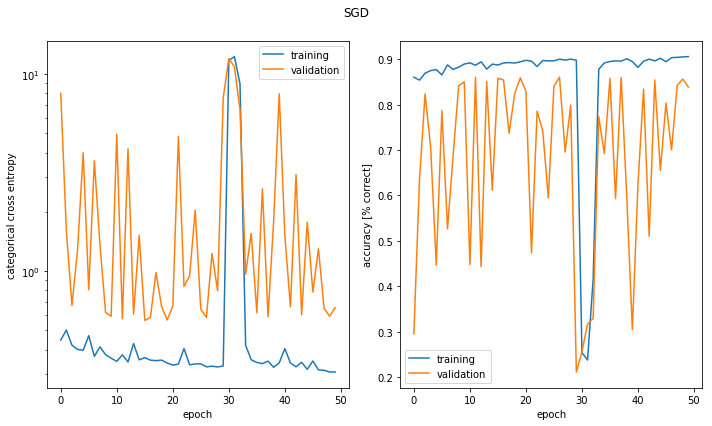

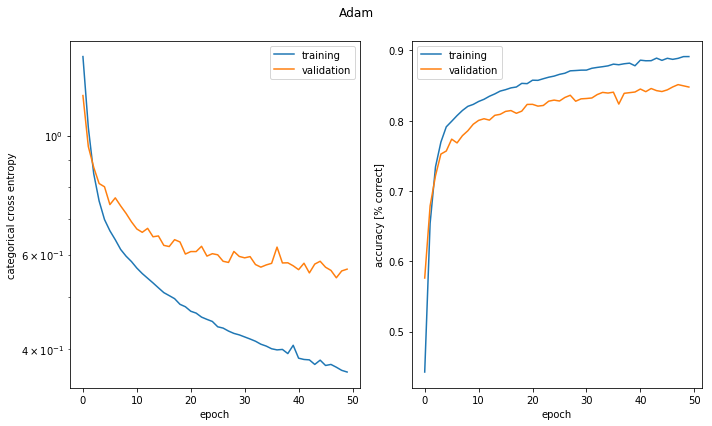

In [17]:
# histories[4] is the one that has smallest loss
plot_history(histories[4], "SGD")
plot_history(adam_history, "Adam")
plt.show()

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is too large, the solucion may oscillate around a value and never achieve a minimum. It may even lead to increasing error during the training period obtening very poor results

B) If the learning rate is too small, the improvement per epoch may be too small too and so, the number of epochs needed to achieve a reasonable results may be extremly large. 

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [17]:
ex3_model = Sequential([
    Dense(64, input_shape=(256,), activation="relu"),
    Dense(5, activation="softmax"),
])

ex3_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam_history = ex3_model.fit(x_train, y_train, epochs=1000, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 32225 samples, validate on 11145 samples
Epoch 1/1000
32225/32225 [==============================] - 1s 27us/step - loss: 1.4422 - acc: 0.4350 - val_loss: 1.1991 - val_acc: 0.5978
Epoch 2/1000
32225/32225 [==============================] - 1s 17us/step - loss: 1.0475 - acc: 0.6811 - val_loss: 0.9464 - val_acc: 0.6891
Epoch 3/1000
32225/32225 [==============================] - 1s 28us/step - loss: 0.8513 - acc: 0.7500 - val_loss: 0.8481 - val_acc: 0.7377
Epoch 4/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.7609 - acc: 0.7749 - val_loss: 0.8103 - val_acc: 0.7444
Epoch 5/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.7126 - acc: 0.7872 - val_loss: 0.7787 - val_acc: 0.7602
Epoch 6/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.6729 - acc: 0.7975 - val_loss: 0.7511 - val_acc: 0.7647
Epoch 7/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.6471 - acc: 0.8023 - val_loss: 0.

32225/32225 [==============================] - 1s 20us/step - loss: 0.2233 - acc: 0.9324 - val_loss: 0.5241 - val_acc: 0.8759
Epoch 118/1000
32225/32225 [==============================] - 1s 25us/step - loss: 0.2252 - acc: 0.9311 - val_loss: 0.5195 - val_acc: 0.8760
Epoch 119/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2214 - acc: 0.9328 - val_loss: 0.5100 - val_acc: 0.8811
Epoch 120/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2224 - acc: 0.9324 - val_loss: 0.5340 - val_acc: 0.8768
Epoch 121/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2202 - acc: 0.9322 - val_loss: 0.5273 - val_acc: 0.8776
Epoch 122/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2196 - acc: 0.9324 - val_loss: 0.5185 - val_acc: 0.8799
Epoch 123/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.2226 - acc: 0.9335 - val_loss: 0.5253 - val_acc: 0.8796
Epoch 124/1000
32225/32225 [

32225/32225 [==============================] - 1s 31us/step - loss: 0.1601 - acc: 0.9501 - val_loss: 0.5823 - val_acc: 0.8791
Epoch 234/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1622 - acc: 0.9497 - val_loss: 0.5936 - val_acc: 0.8794
Epoch 235/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1616 - acc: 0.9507 - val_loss: 0.5729 - val_acc: 0.8834
Epoch 236/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1599 - acc: 0.9494 - val_loss: 0.5911 - val_acc: 0.8776
Epoch 237/1000
32225/32225 [==============================] - 1s 28us/step - loss: 0.1578 - acc: 0.9514 - val_loss: 0.5739 - val_acc: 0.8810
Epoch 238/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.1612 - acc: 0.9495 - val_loss: 0.5903 - val_acc: 0.8794
Epoch 239/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.1554 - acc: 0.9523 - val_loss: 0.5717 - val_acc: 0.8827
Epoch 240/1000
32225/32225 [

32225/32225 [==============================] - 1s 24us/step - loss: 0.1315 - acc: 0.9588 - val_loss: 0.6319 - val_acc: 0.8834
Epoch 350/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1318 - acc: 0.9595 - val_loss: 0.6329 - val_acc: 0.8854
Epoch 351/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1348 - acc: 0.9582 - val_loss: 0.6379 - val_acc: 0.8828
Epoch 352/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1312 - acc: 0.9594 - val_loss: 0.6431 - val_acc: 0.8825
Epoch 353/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1341 - acc: 0.9574 - val_loss: 0.6405 - val_acc: 0.8840
Epoch 354/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1281 - acc: 0.9596 - val_loss: 0.6407 - val_acc: 0.8827
Epoch 355/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1279 - acc: 0.9606 - val_loss: 0.6286 - val_acc: 0.8836
Epoch 356/1000
32225/32225 [

32225/32225 [==============================] - 1s 18us/step - loss: 0.1100 - acc: 0.9659 - val_loss: 0.6881 - val_acc: 0.8807
Epoch 466/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1116 - acc: 0.9660 - val_loss: 0.6965 - val_acc: 0.8819
Epoch 467/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1104 - acc: 0.9669 - val_loss: 0.6851 - val_acc: 0.8821
Epoch 468/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1130 - acc: 0.9646 - val_loss: 0.6776 - val_acc: 0.8841
Epoch 469/1000
32225/32225 [==============================] - 1s 40us/step - loss: 0.1136 - acc: 0.9651 - val_loss: 0.6849 - val_acc: 0.8827
Epoch 470/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1139 - acc: 0.9647 - val_loss: 0.6950 - val_acc: 0.8823
Epoch 471/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1114 - acc: 0.9655 - val_loss: 0.6833 - val_acc: 0.8825
Epoch 472/1000
32225/32225 [

32225/32225 [==============================] - 1s 20us/step - loss: 0.0961 - acc: 0.9704 - val_loss: 0.7367 - val_acc: 0.8817
Epoch 582/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0938 - acc: 0.9719 - val_loss: 0.7157 - val_acc: 0.8819
Epoch 583/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.1044 - acc: 0.9677 - val_loss: 0.7374 - val_acc: 0.8834
Epoch 584/1000
32225/32225 [==============================] - 1s 20us/step - loss: 0.1000 - acc: 0.9695 - val_loss: 0.7308 - val_acc: 0.8832
Epoch 585/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.1001 - acc: 0.9691 - val_loss: 0.7299 - val_acc: 0.8844
Epoch 586/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0917 - acc: 0.9732 - val_loss: 0.7261 - val_acc: 0.8822
Epoch 587/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0969 - acc: 0.9694 - val_loss: 0.7278 - val_acc: 0.8836
Epoch 588/1000
32225/32225 [

32225/32225 [==============================] - 1s 17us/step - loss: 0.0896 - acc: 0.9719 - val_loss: 0.7764 - val_acc: 0.8800
Epoch 698/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0858 - acc: 0.9739 - val_loss: 0.7968 - val_acc: 0.8782
Epoch 699/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0895 - acc: 0.9723 - val_loss: 0.8075 - val_acc: 0.8775
Epoch 700/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0860 - acc: 0.9736 - val_loss: 0.7782 - val_acc: 0.8825
Epoch 701/1000
32225/32225 [==============================] - 1s 31us/step - loss: 0.0895 - acc: 0.9715 - val_loss: 0.7658 - val_acc: 0.8836
Epoch 702/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0845 - acc: 0.9735 - val_loss: 0.7633 - val_acc: 0.8823
Epoch 703/1000
32225/32225 [==============================] - 1s 17us/step - loss: 0.0870 - acc: 0.9729 - val_loss: 0.7883 - val_acc: 0.8798
Epoch 704/1000
32225/32225 [

32225/32225 [==============================] - 1s 17us/step - loss: 0.0749 - acc: 0.9761 - val_loss: 0.8281 - val_acc: 0.8777
Epoch 814/1000
32225/32225 [==============================] - 1s 29us/step - loss: 0.0793 - acc: 0.9754 - val_loss: 0.8231 - val_acc: 0.8783
Epoch 815/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0725 - acc: 0.9778 - val_loss: 0.8172 - val_acc: 0.8801
Epoch 816/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0730 - acc: 0.9778 - val_loss: 0.8358 - val_acc: 0.8781
Epoch 817/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0767 - acc: 0.9771 - val_loss: 0.8137 - val_acc: 0.8800
Epoch 818/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0849 - acc: 0.9733 - val_loss: 0.8340 - val_acc: 0.8747
Epoch 819/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0746 - acc: 0.9775 - val_loss: 0.8139 - val_acc: 0.8806
Epoch 820/1000
32225/32225 [

32225/32225 [==============================] - 1s 18us/step - loss: 0.0686 - acc: 0.9791 - val_loss: 0.8544 - val_acc: 0.8805
Epoch 930/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0697 - acc: 0.9785 - val_loss: 0.8538 - val_acc: 0.8790
Epoch 931/1000
32225/32225 [==============================] - 1s 19us/step - loss: 0.0749 - acc: 0.9762 - val_loss: 0.8494 - val_acc: 0.8772
Epoch 932/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0649 - acc: 0.9807 - val_loss: 0.8810 - val_acc: 0.8754
Epoch 933/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0728 - acc: 0.9783 - val_loss: 0.8688 - val_acc: 0.8772
Epoch 934/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0637 - acc: 0.9817 - val_loss: 0.8552 - val_acc: 0.8784
Epoch 935/1000
32225/32225 [==============================] - 1s 18us/step - loss: 0.0698 - acc: 0.9793 - val_loss: 0.8755 - val_acc: 0.8794
Epoch 936/1000
32225/32225 [

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

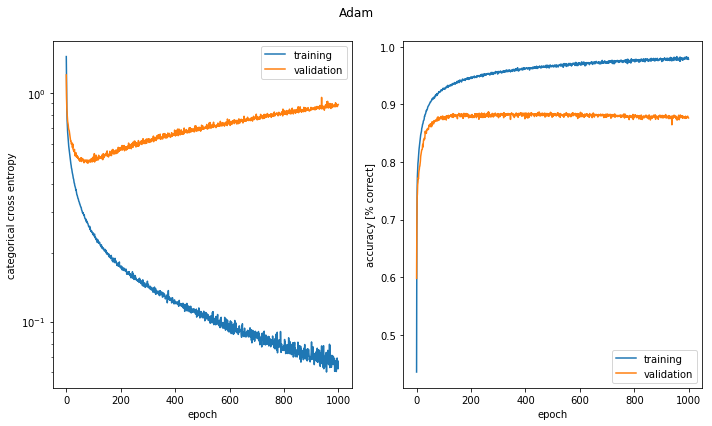

In [18]:
plot_history(adam_history, "Adam")
plt.show()

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [34]:
hidden_n = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]

accuracy = {}
losses = {}

for params in hidden_n:
    print("Number of hidden units: {}".format(params))
    accuracy[params] = []
    losses[params] = []
    for n in range(5):
        print("Iteration number {}".format(n))
        ex4_model = Sequential([
    Dense(params, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
    ])

        ex4_model.compile(optimizer=SGD(lr=0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        h = ex4_model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=200,  batch_size=128, verbose=0)
        accuracy[params].append(h.history.get('val_acc')[-1]) 
        losses[params].append(h.history.get('val_loss')[-1])

Number of hidden units: 10
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 50
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 100
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 150
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 200
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 250
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 300
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden units: 350
Iteration number 0
Iteration number 1
Iteration number 2
Iteration number 3
Iteration number 4
Number of hidden u

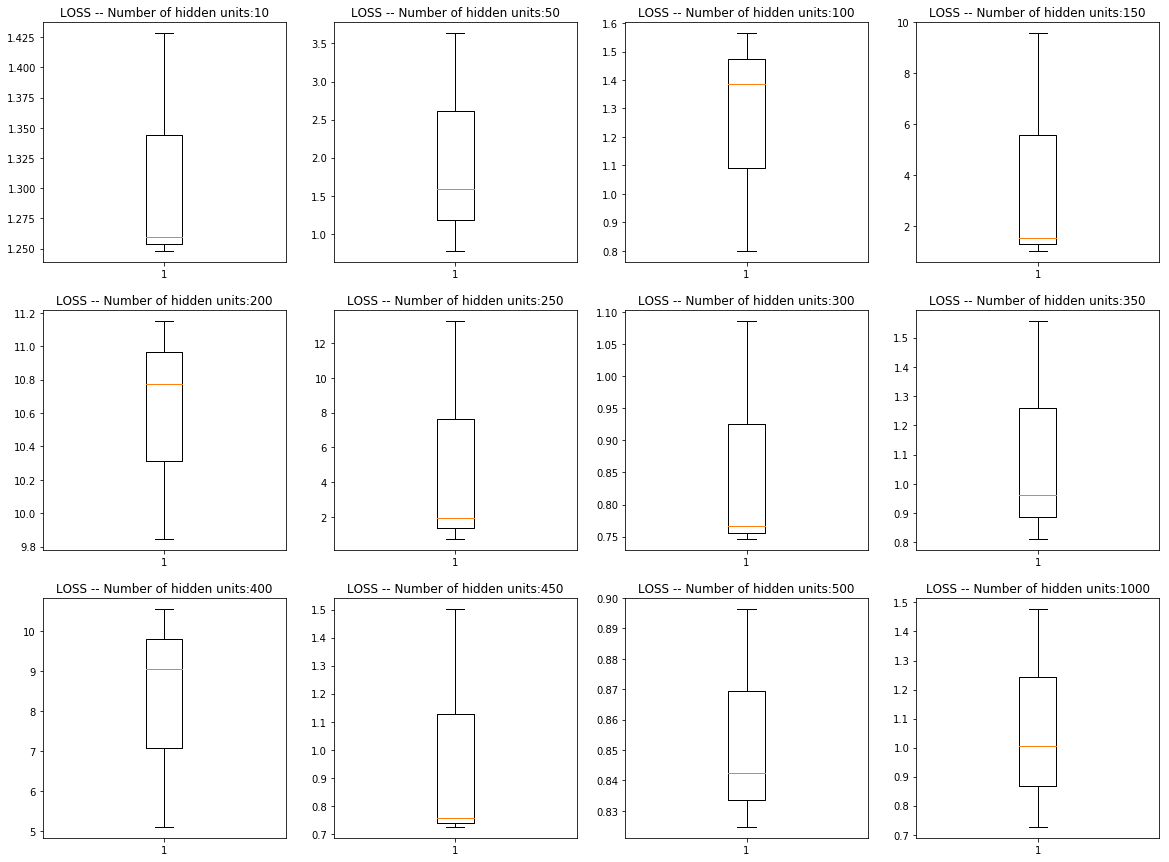

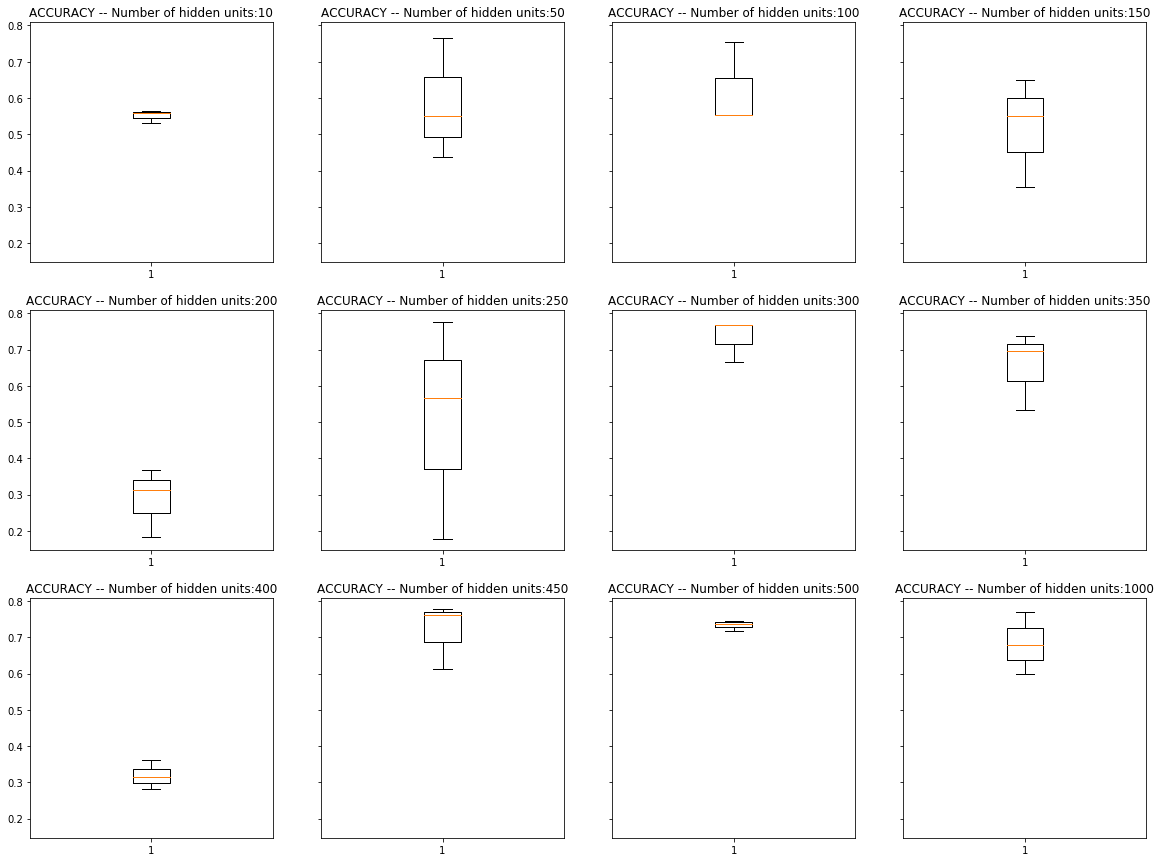

In [33]:
fig1, axes1 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=False)
fig2, axes2 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)
fs = 12
for n in range(len(hidden_n)):
    row = int(n/4)
    col = n%4
    data_loss = losses[hidden_n[n]]
    data_acc = accuracy[hidden_n[n]]
    
    axes1[row, col].boxplot(data_loss, manage_xticks=True)
    axes1[row, col].set_title('LOSS -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
    axes2[row, col].boxplot(data_acc, manage_xticks=True)
    axes2[row, col].set_title('ACCURACY -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
plt.show()

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [40]:
ex5_1_model = Sequential([
    Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
])

ex5_1_model.summary()

nh_2 = 77
ex5_2_model = Sequential([
    Dense(nh_2, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_2, activation='relu'),
    Dense(5, activation='softmax')
])

ex5_2_model.summary()

nh_3 = 66
ex5_3_model = Sequential([
    Dense(nh_3, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_3, activation='relu'),
    Dense(nh_3, activation='relu'),
    Dense(5, activation='softmax')
])

ex5_3_model.summary()

nh_4 = 59
ex5_4_model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(5, activation='softmax')
])

ex5_4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_266 (Dense)            (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_267 (Dense)            (None, 77)                19789     
_________________________________________________________________
dense_268 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_269 (Dense)            (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
__

In [54]:
models = [ex5_1_model, ex5_2_model, ex5_3_model, ex5_4_model]

accurancy = {}
losses = {}

for model in models:
    print("Model: {}".format(model))
    accuracy[model] = []
    losses[model] = []
    for n in range(5):
        print("Iteration number {}".format(n))
        model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
        
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300,  batch_size=128, verbose=0)
        print('Test accuracy: {}'.format(h.history.get('val_acc')[-1]))
        accuracy[model].append(h.history.get('val_acc')[-1]) 
        print('Test loss: {}'.format(h.history.get('val_loss')[-1]))
        losses[model].append(h.history.get('val_loss')[-1])

Model: <keras.models.Sequential object at 0x7f8c4d633d68>
Iteration number 0
Test accuracy: 0.8736459870223398
Test loss: 0.5392971325836294
Iteration number 1
Test accuracy: 0.8685376660275612
Test loss: 0.5699515224735705
Iteration number 2
Test accuracy: 0.871799605987977
Test loss: 0.5778381768733277
Iteration number 3
Test accuracy: 0.8755539142985699
Test loss: 0.5755349242117885
Iteration number 4
Test accuracy: 0.8755539142985699
Test loss: 0.5974618244910698
Model: <keras.models.Sequential object at 0x7f8c4d5e2d68>
Iteration number 0
Test accuracy: 0.8711841457116668
Test loss: 0.5488215002856308
Iteration number 1
Test accuracy: 0.8643525356673537
Test loss: 0.6320714338667459
Iteration number 2
Test accuracy: 0.859675037074359
Test loss: 0.7142641563711349
Iteration number 3
Test accuracy: 0.8376415560305382
Test loss: 0.9197521816621796
Iteration number 4
Test accuracy: 0.8633062529892596
Test loss: 0.827531755939016
Model: <keras.models.Sequential object at 0x7f8c4d5533c8>

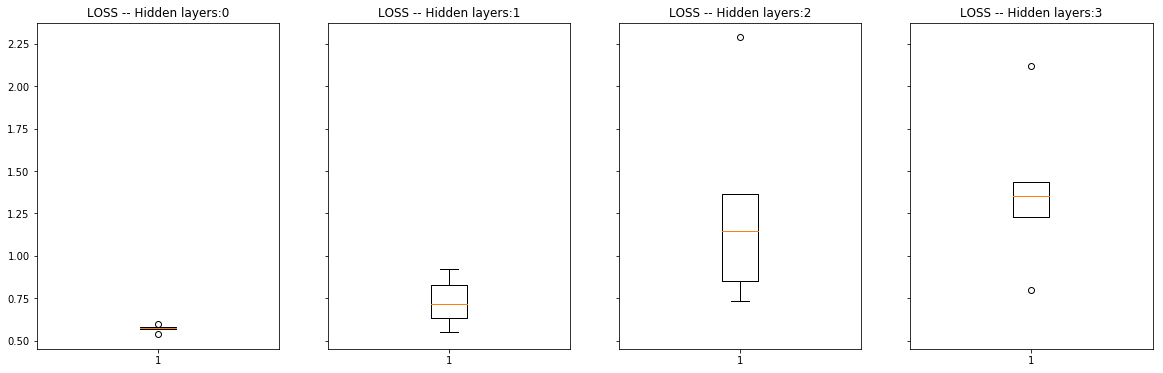

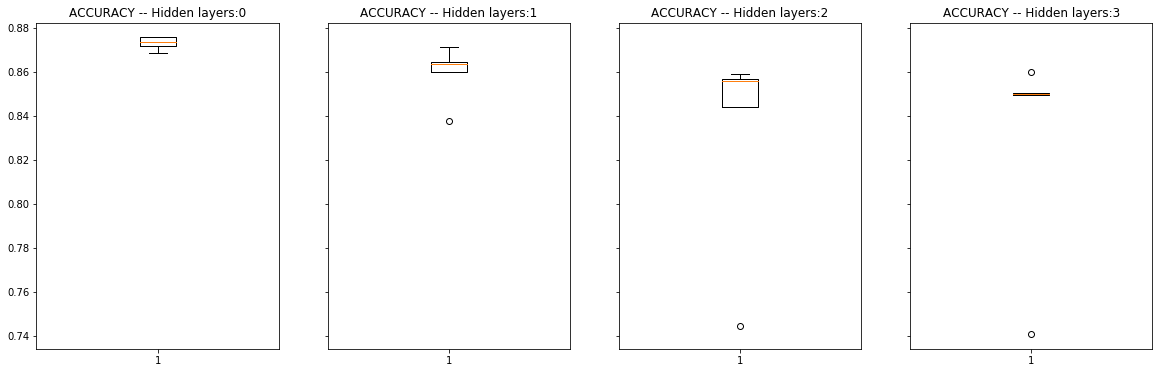

In [62]:
fig1, axes1 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fig2, axes2 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fs = 12

for n in range(len(models)):
    row = 0
    col = n%4

    data_loss = losses[models[n]]
    data_acc = accuracy[models[n]]
    
    axes1[col].boxplot(data_loss, manage_xticks=True)
    axes1[col].set_title('LOSS -- Hidden layers:{}'.format(n), fontsize=fs)
    
    axes2[col].boxplot(data_acc, manage_xticks=True)
    axes2[col].set_title('ACCURACY -- Hidden layers:{}'.format(n), fontsize=fs)
    
plt.show()

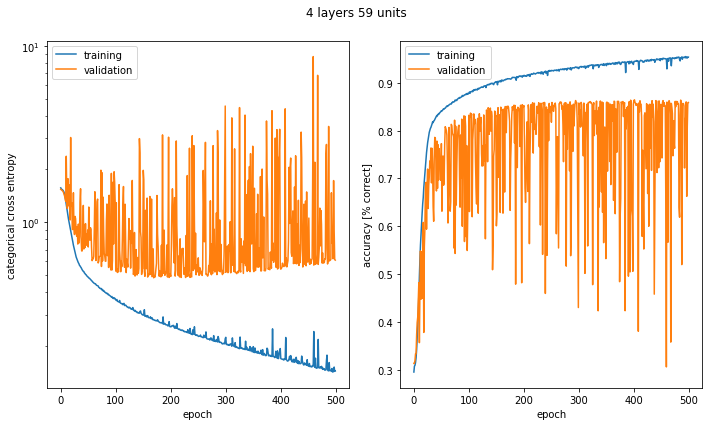

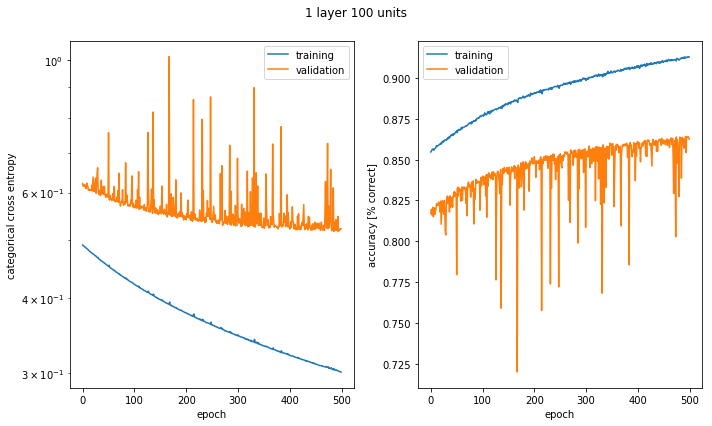

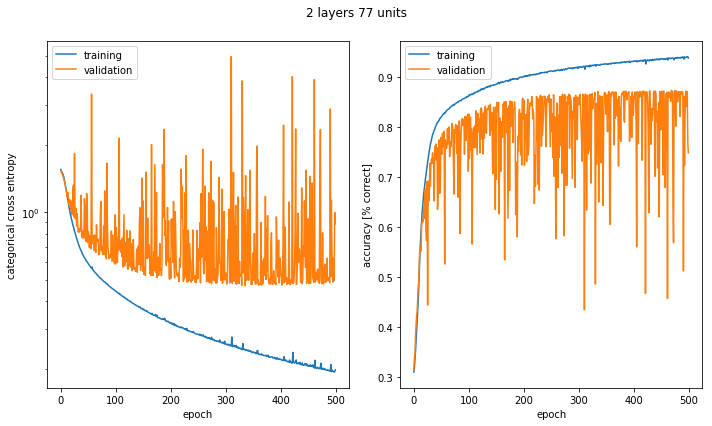

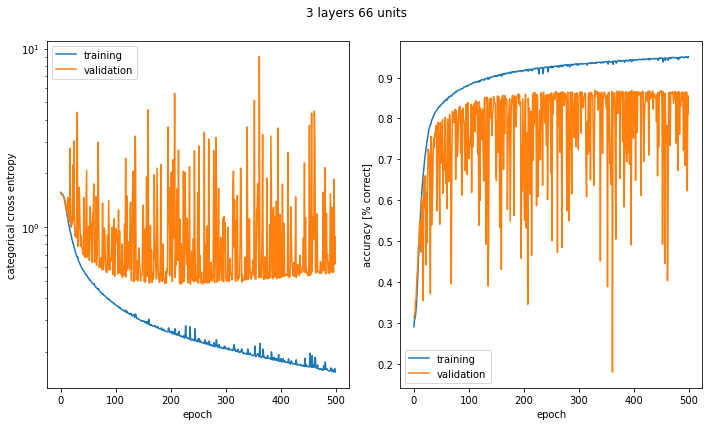

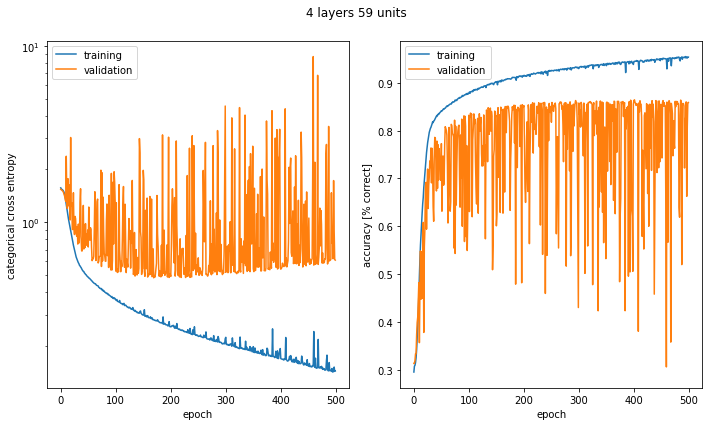

In [46]:
plot_history(h5_1,'1 layer 100 units')
plot_history(h5_2,'2 layers 77 units')
plot_history(h5_3,'3 layers 66 units')
plot_history(h5_4,'4 layers 59 units')

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [10]:
momentums = [0.99, 0.95, 0.9]
histories = []

for momentum in momentums:
    model = Sequential([
        Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                    bias_initializer='random_uniform'),
        BatchNormalization(momentum=momentum),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    histories.append(model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=100, batch_size=128, verbose=0))
    print("Accuracy with BatchN {}: {}".format(momentum, histories[-1].history.get('acc')[-1]))

Train on 39523 samples, validate on 14002 samples
Epoch 1/100
39523/39523 [==============================] - 1s 35us/step - loss: 1.2389 - acc: 0.5492 - val_loss: 0.9842 - val_acc: 0.6725
Epoch 2/100
39523/39523 [==============================] - 2s 40us/step - loss: 0.9014 - acc: 0.7117 - val_loss: 0.8683 - val_acc: 0.7227
Epoch 3/100
39523/39523 [==============================] - 1s 35us/step - loss: 0.7824 - acc: 0.7552 - val_loss: 0.7835 - val_acc: 0.7465
Epoch 4/100
39523/39523 [==============================] - 2s 45us/step - loss: 0.7127 - acc: 0.7796 - val_loss: 0.7330 - val_acc: 0.7748
Epoch 5/100
39523/39523 [==============================] - 1s 38us/step - loss: 0.6636 - acc: 0.7967 - val_loss: 0.7130 - val_acc: 0.7706
Epoch 6/100
39523/39523 [==============================] - 3s 77us/step - loss: 0.6317 - acc: 0.8056 - val_loss: 0.6972 - val_acc: 0.7775
Epoch 7/100
39523/39523 [==============================] - 3s 83us/step - loss: 0.6029 - acc: 0.8141 - val_loss: 0.6629 - 

39523/39523 [==============================] - 1s 33us/step - loss: 0.3011 - acc: 0.9063 - val_loss: 0.4510 - val_acc: 0.8818
Epoch 60/100
39523/39523 [==============================] - 1s 33us/step - loss: 0.2971 - acc: 0.9088 - val_loss: 0.4624 - val_acc: 0.8799
Epoch 61/100
39523/39523 [==============================] - 1s 35us/step - loss: 0.2963 - acc: 0.9088 - val_loss: 0.4561 - val_acc: 0.8819
Epoch 62/100
39523/39523 [==============================] - 1s 34us/step - loss: 0.2964 - acc: 0.9080 - val_loss: 0.4599 - val_acc: 0.8767
Epoch 63/100
39523/39523 [==============================] - 1s 34us/step - loss: 0.2906 - acc: 0.9103 - val_loss: 0.4914 - val_acc: 0.8653
Epoch 64/100
39523/39523 [==============================] - 2s 59us/step - loss: 0.2934 - acc: 0.9091 - val_loss: 0.4739 - val_acc: 0.8713
Epoch 65/100
39523/39523 [==============================] - 1s 33us/step - loss: 0.2907 - acc: 0.9098 - val_loss: 0.5332 - val_acc: 0.8508
Epoch 66/100
39523/39523 [==============

39523/39523 [==============================] - 1s 24us/step - loss: 0.4349 - acc: 0.8703 - val_loss: 0.5356 - val_acc: 0.8480
Epoch 18/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.4265 - acc: 0.8708 - val_loss: 0.5172 - val_acc: 0.8527
Epoch 19/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.4193 - acc: 0.8726 - val_loss: 0.5317 - val_acc: 0.8427
Epoch 20/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.4123 - acc: 0.8746 - val_loss: 0.5116 - val_acc: 0.8522
Epoch 21/100
39523/39523 [==============================] - 1s 28us/step - loss: 0.4059 - acc: 0.8776 - val_loss: 0.5004 - val_acc: 0.8561
Epoch 22/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.4003 - acc: 0.8796 - val_loss: 0.5253 - val_acc: 0.8494
Epoch 23/100
39523/39523 [==============================] - 2s 40us/step - loss: 0.3933 - acc: 0.8814 - val_loss: 0.5400 - val_acc: 0.8435
Epoch 24/100
39523/39523 [==============

39523/39523 [==============================] - 1s 23us/step - loss: 0.2716 - acc: 0.9151 - val_loss: 0.4619 - val_acc: 0.8778
Epoch 77/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.2680 - acc: 0.9159 - val_loss: 0.5035 - val_acc: 0.8679
Epoch 78/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.2702 - acc: 0.9153 - val_loss: 0.5052 - val_acc: 0.8653
Epoch 79/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.2674 - acc: 0.9161 - val_loss: 0.4705 - val_acc: 0.8762
Epoch 80/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.2674 - acc: 0.9162 - val_loss: 0.4787 - val_acc: 0.8731
Epoch 81/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.2660 - acc: 0.9166 - val_loss: 0.5397 - val_acc: 0.8532
Epoch 82/100
39523/39523 [==============================] - 1s 35us/step - loss: 0.2645 - acc: 0.9176 - val_loss: 0.4681 - val_acc: 0.8789
Epoch 83/100
39523/39523 [==============

39523/39523 [==============================] - 2s 48us/step - loss: 0.3624 - acc: 0.8894 - val_loss: 0.5559 - val_acc: 0.8364
Epoch 35/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.3540 - acc: 0.8935 - val_loss: 0.4748 - val_acc: 0.8702
Epoch 36/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.3547 - acc: 0.8908 - val_loss: 0.4722 - val_acc: 0.8714
Epoch 37/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.3516 - acc: 0.8934 - val_loss: 0.4639 - val_acc: 0.8728
Epoch 38/100
39523/39523 [==============================] - 2s 43us/step - loss: 0.3481 - acc: 0.8956 - val_loss: 0.4883 - val_acc: 0.8662
Epoch 39/100
39523/39523 [==============================] - 1s 35us/step - loss: 0.3471 - acc: 0.8940 - val_loss: 0.4659 - val_acc: 0.8710
Epoch 40/100
39523/39523 [==============================] - 1s 23us/step - loss: 0.3432 - acc: 0.8943 - val_loss: 0.5435 - val_acc: 0.8488
Epoch 41/100
39523/39523 [==============

39523/39523 [==============================] - 1s 30us/step - loss: 0.2676 - acc: 0.9171 - val_loss: 0.5863 - val_acc: 0.8462
Epoch 94/100
39523/39523 [==============================] - 1s 31us/step - loss: 0.2637 - acc: 0.9166 - val_loss: 0.4817 - val_acc: 0.8762
Epoch 95/100
39523/39523 [==============================] - 1s 37us/step - loss: 0.2628 - acc: 0.9183 - val_loss: 0.5132 - val_acc: 0.8702
Epoch 96/100
39523/39523 [==============================] - 1s 29us/step - loss: 0.2656 - acc: 0.9171 - val_loss: 0.4837 - val_acc: 0.8788
Epoch 97/100
39523/39523 [==============================] - 1s 29us/step - loss: 0.2614 - acc: 0.9177 - val_loss: 0.5136 - val_acc: 0.8652
Epoch 98/100
39523/39523 [==============================] - 1s 29us/step - loss: 0.2623 - acc: 0.9167 - val_loss: 0.4897 - val_acc: 0.8767
Epoch 99/100
39523/39523 [==============================] - 2s 47us/step - loss: 0.2651 - acc: 0.9168 - val_loss: 0.4841 - val_acc: 0.8749
Epoch 100/100
39523/39523 [=============

In [11]:
rates = [0.1, 0.2, 0.3, 0.4, 0.5]
momentum = 0.99
histories = []

for rate in rates:
    model = Sequential([
        Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                    bias_initializer='random_uniform'),
        BatchNormalization(momentum=momentum),
        Dropout(rate),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    histories.append(model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, batch_size=128, verbose=0))
    print("Accuracy with rate {}: {}".format(rate, histories[-1].history.get('acc')[-1]))

Accuracy with rate 0.1: 0.9217417706100546
Accuracy with rate 0.2: 0.9038281506623762
Accuracy with rate 0.3: 0.8895326772175425
Accuracy with rate 0.4: 0.8699997470249964
Accuracy with rate 0.5: 0.8483161703689021


In [14]:
rates = [0.005, 0.001, 0.0005]

for rate in rates:
    model = Sequential([
        Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
              bias_initializer='random_uniform', 
              kernel_regularizer=regularizers.l1(rate),
              bias_regularizer=regularizers.l1(rate)),              
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    histories.append(model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, batch_size=128, verbose=0))
    print("Accuracy with L1, rate {}: {}".format(rate, histories[-1].history.get('acc')[-1]))

Accuracy with L1, rate 0.005: 0.3507071831885811
Accuracy with L1, rate 0.001: 0.813020266666588
Accuracy with L1, rate 0.0005: 0.8449763428241024


In [15]:
for rate in rates:
    model = Sequential([
        Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
              bias_initializer='random_uniform', 
              kernel_regularizer=regularizers.l2(rate),
              bias_regularizer=regularizers.l2(rate)),            
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    histories.append(model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, batch_size=128, verbose=0))
    print("Accuracy with L2, rate {}: {}".format(rate, histories[-1].history.get('acc')[-1]))

Accuracy with L2, rate 0.005: 0.8363484553117108
Accuracy with L2, rate 0.001: 0.8693925055949471
Accuracy with L2, rate 0.0005: 0.8767047035556282


In [17]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform',
          kernel_regularizer=regularizers.l2(0.0005),
          bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
histories.append(model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300, batch_size=128, verbose=1))
print("Accuracy with BatchN {}: {}".format(momentum, histories[-1].history.get('acc')[-1]))

Train on 39523 samples, validate on 14002 samples
Epoch 1/300
39523/39523 [==============================] - 3s 84us/step - loss: 1.2224 - acc: 0.5600 - val_loss: 0.9821 - val_acc: 0.6715
Epoch 2/300
39523/39523 [==============================] - 2s 41us/step - loss: 0.8683 - acc: 0.7292 - val_loss: 0.8485 - val_acc: 0.7285
Epoch 3/300
39523/39523 [==============================] - 1s 35us/step - loss: 0.7533 - acc: 0.7716 - val_loss: 0.7542 - val_acc: 0.7657
Epoch 4/300
39523/39523 [==============================] - 1s 36us/step - loss: 0.6881 - acc: 0.7925 - val_loss: 0.7351 - val_acc: 0.7667
Epoch 5/300
39523/39523 [==============================] - 2s 58us/step - loss: 0.6470 - acc: 0.8049 - val_loss: 0.6876 - val_acc: 0.7892
Epoch 6/300
39523/39523 [==============================] - 1s 33us/step - loss: 0.6158 - acc: 0.8145 - val_loss: 0.6521 - val_acc: 0.8016
Epoch 7/300
39523/39523 [==============================] - 2s 39us/step - loss: 0.5896 - acc: 0.8256 - val_loss: 0.6402 - 

39523/39523 [==============================] - 1s 31us/step - loss: 0.3246 - acc: 0.9058 - val_loss: 0.4919 - val_acc: 0.8755
Epoch 60/300
39523/39523 [==============================] - 1s 30us/step - loss: 0.3168 - acc: 0.9083 - val_loss: 0.4954 - val_acc: 0.8727
Epoch 61/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.3190 - acc: 0.9070 - val_loss: 0.5252 - val_acc: 0.8694
Epoch 62/300
39523/39523 [==============================] - 1s 30us/step - loss: 0.3150 - acc: 0.9082 - val_loss: 0.5002 - val_acc: 0.8767
Epoch 63/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.3154 - acc: 0.9087 - val_loss: 0.5000 - val_acc: 0.8750
Epoch 64/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.3158 - acc: 0.9074 - val_loss: 0.6121 - val_acc: 0.8341
Epoch 65/300
39523/39523 [==============================] - 1s 30us/step - loss: 0.3150 - acc: 0.9103 - val_loss: 0.4894 - val_acc: 0.8810
Epoch 66/300
39523/39523 [==============

Epoch 118/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.2771 - acc: 0.9219 - val_loss: 0.5309 - val_acc: 0.8738
Epoch 119/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.2751 - acc: 0.9209 - val_loss: 0.5773 - val_acc: 0.8645
Epoch 120/300
39523/39523 [==============================] - 1s 28us/step - loss: 0.2676 - acc: 0.9242 - val_loss: 0.5195 - val_acc: 0.8752
Epoch 121/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.2722 - acc: 0.9234 - val_loss: 0.5224 - val_acc: 0.8782
Epoch 122/300
39523/39523 [==============================] - 1s 31us/step - loss: 0.2734 - acc: 0.9209 - val_loss: 0.5216 - val_acc: 0.8756
Epoch 123/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.2714 - acc: 0.9220 - val_loss: 0.8150 - val_acc: 0.8008
Epoch 124/300
39523/39523 [==============================] - 2s 54us/step - loss: 0.2703 - acc: 0.9229 - val_loss: 0.5250 - val_acc: 0.8778
Epoch 125/300
39523/

39523/39523 [==============================] - 1s 32us/step - loss: 0.2564 - acc: 0.9284 - val_loss: 0.5359 - val_acc: 0.8805
Epoch 177/300
39523/39523 [==============================] - 1s 28us/step - loss: 0.2505 - acc: 0.9287 - val_loss: 0.6063 - val_acc: 0.8634
Epoch 178/300
39523/39523 [==============================] - 2s 50us/step - loss: 0.2515 - acc: 0.9286 - val_loss: 0.5174 - val_acc: 0.8859
Epoch 179/300
39523/39523 [==============================] - 1s 27us/step - loss: 0.2526 - acc: 0.9286 - val_loss: 0.5462 - val_acc: 0.8744
Epoch 180/300
39523/39523 [==============================] - 2s 53us/step - loss: 0.2525 - acc: 0.9292 - val_loss: 0.5977 - val_acc: 0.8656
Epoch 181/300
39523/39523 [==============================] - 1s 27us/step - loss: 0.2487 - acc: 0.9305 - val_loss: 0.5378 - val_acc: 0.8799
Epoch 182/300
39523/39523 [==============================] - 1s 25us/step - loss: 0.2501 - acc: 0.9293 - val_loss: 0.5664 - val_acc: 0.8707
Epoch 183/300
39523/39523 [=======

39523/39523 [==============================] - 2s 56us/step - loss: 0.2436 - acc: 0.9325 - val_loss: 0.6005 - val_acc: 0.8696
Epoch 235/300
39523/39523 [==============================] - 2s 48us/step - loss: 0.2437 - acc: 0.9322 - val_loss: 0.6999 - val_acc: 0.8413
Epoch 236/300
39523/39523 [==============================] - 2s 40us/step - loss: 0.2413 - acc: 0.9337 - val_loss: 0.5596 - val_acc: 0.8804
Epoch 237/300
39523/39523 [==============================] - 2s 40us/step - loss: 0.2433 - acc: 0.9328 - val_loss: 0.5645 - val_acc: 0.8769
Epoch 238/300
39523/39523 [==============================] - 2s 41us/step - loss: 0.2399 - acc: 0.9350 - val_loss: 0.6010 - val_acc: 0.8678
Epoch 239/300
39523/39523 [==============================] - 2s 40us/step - loss: 0.2383 - acc: 0.9337 - val_loss: 0.5740 - val_acc: 0.8777
Epoch 240/300
39523/39523 [==============================] - 2s 63us/step - loss: 0.2369 - acc: 0.9342 - val_loss: 0.5888 - val_acc: 0.8728
Epoch 241/300
39523/39523 [=======

39523/39523 [==============================] - 2s 39us/step - loss: 0.2309 - acc: 0.9375 - val_loss: 0.6398 - val_acc: 0.8639
Epoch 293/300
39523/39523 [==============================] - 2s 55us/step - loss: 0.2297 - acc: 0.9381 - val_loss: 0.5997 - val_acc: 0.8792
Epoch 294/300
39523/39523 [==============================] - 2s 43us/step - loss: 0.2362 - acc: 0.9361 - val_loss: 0.5852 - val_acc: 0.8764
Epoch 295/300
39523/39523 [==============================] - 1s 34us/step - loss: 0.2318 - acc: 0.9369 - val_loss: 0.5826 - val_acc: 0.8784
Epoch 296/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.2332 - acc: 0.9368 - val_loss: 0.6654 - val_acc: 0.8559
Epoch 297/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.2335 - acc: 0.9377 - val_loss: 0.6783 - val_acc: 0.8507
Epoch 298/300
39523/39523 [==============================] - 1s 29us/step - loss: 0.2302 - acc: 0.9390 - val_loss: 0.5957 - val_acc: 0.8742
Epoch 299/300
39523/39523 [=======

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [64]:
ex7_model = Sequential()
ex7_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(256,)))
ex7_model.add(Conv2D(64, (3, 3), activation='relu'))
ex7_model.add(MaxPooling2D(pool_size=(2, 2)))
ex7_model.add(Dropout(0.25))
ex7_model.add(Flatten())
ex7_model.add(Dense(128, activation='relu'))
ex7_model.add(Dropout(0.5))
ex7_model.add(Dense(5, activation='softmax'))

ex7_model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

ex7_model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))
score = ex7_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: Input 0 is incompatible with layer conv2d_1: expected ndim=4, found ndim=2